In [1]:
import torch
import torchvision

model = torchvision.models.alexnet(pretrained=False)
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 2)

In [2]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [3]:
device = torch.device('cuda')
model = model.to(device)

In [4]:
import cv2
import numpy as np

mean = 255.0 * np.array([0.485, 0.456, 0.406])
stdev = 255.0 * np.array([0.229, 0.224, 0.225])

normalize = torchvision.transforms.Normalize(mean, stdev)

def preprocess(camera_value):
    global device, normalize
    x = camera_value
#     x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = x.transpose((2, 0, 1))
    x = torch.from_numpy(x).float()
    x = normalize(x)
    x = x.to(device)
    x = x[None, ...]
    return x

In [5]:
from IPython.display import display, clear_output
import IPython
from PIL import Image
from io import BytesIO

def gstreamer_pipeline(
    capture_width=1280,
    capture_height=720,
    display_width=1280,
    display_height=720,
    framerate=60,
    flip_method=0,
):
    return (
        "nvarguscamerasrc ! "
        "video/x-raw(memory:NVMM), "
        "width=(int)%d, height=(int)%d, "
        "format=(string)NV12, framerate=(fraction)%d/1 ! "
        "nvvidconv flip-method=%d ! "
        "video/x-raw, width=(int)%d, height=(int)%d, format=(string)BGRx ! "
        "videoconvert ! "
        "video/x-raw, format=(string)BGR ! appsink"
        % (
            capture_width,
            capture_height,
            framerate,
            flip_method,
            display_width,
            display_height,
        )
    )

def render(arr, fmt='jpeg'):
    f = BytesIO()
    Image.fromarray(arr).save(f, fmt)
    display(IPython.display.Image(data=f.getvalue()))
    clear_output(wait=True)

0.4695684313774109


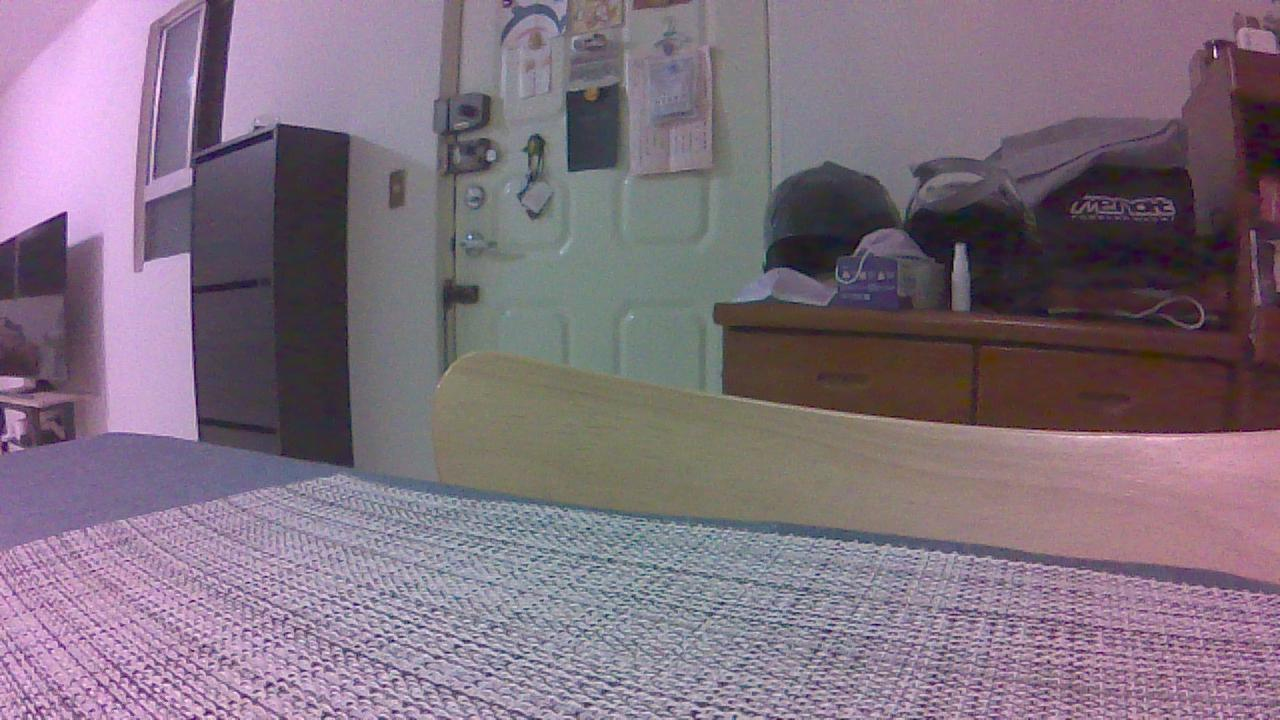

In [ ]:
import torch.nn.functional as F

gst = gstreamer_pipeline(640, 360, 640, 360, 24)
cap = cv2.VideoCapture(gstreamer_pipeline(), cv2.CAP_GSTREAMER)

try:
    while True:
        success, img = cap.read()
        if success:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            x = preprocess(img)
            
            y = model(x)
    
            # we apply the `softmax` function to normalize the output vector so it sums to 1 (which makes it a probability distribution)
            y = F.softmax(y, dim=1)

            prob_blocked = float(y.flatten()[0])
            print(prob_blocked)
            render(img)

        else:
            print('camera error')
except KeyboardInterrupt:
    print('stop')
    cap.release()